# Notebook 2: XGBoost Training & Comparison
Trains XGBoost on each descriptor CSV from Notebook 1.
Compares R2, MAE, RMSE across all scenarios.

**CSV naming convention:**
- `desc_{TYPE}_w{WINDOW}.csv` for individual types per window
- `desc_ALL_w{WINDOW}.csv` for all types combined per window
- `desc_ALL_multiwindow.csv` for all types across all windows

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import warnings
from sklearn.model_selection import KFold, cross_val_score, LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
# ============================================================
# PATHS
# ============================================================
BASE_DIR = r"C:\Users\AbCMS_Lab\Desktop\Keshav-DDP"
CSV_DIR = os.path.join(BASE_DIR, "Weight-contribution", "contribution-model")

# Find all descriptor CSVs
csv_files = sorted(glob.glob(os.path.join(CSV_DIR, "desc_*.csv")))
print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    name = os.path.basename(f)
    df_tmp = pd.read_csv(f)
    feat_cols = [c for c in df_tmp.columns if c not in 
                 ['uid','Formula','alpha_R','heavy1_el','heavy2_el','heavy1_mass',
                  'heavy2_mass','n_elements','window']]
    print(f"  {name}: {len(df_tmp)} rows, {len(feat_cols)} features")

Found 22 CSV files:
  desc_ALL_multiwindow.csv: 99 rows, 54 features
  desc_ALL_w005.csv: 99 rows, 18 features
  desc_ALL_w01.csv: 99 rows, 18 features
  desc_ALL_w05.csv: 99 rows, 18 features
  desc_A_w005.csv: 99 rows, 2 features
  desc_A_w01.csv: 99 rows, 2 features
  desc_A_w05.csv: 99 rows, 2 features
  desc_B_w005.csv: 99 rows, 2 features
  desc_B_w01.csv: 99 rows, 2 features
  desc_B_w05.csv: 99 rows, 2 features
  desc_C_w005.csv: 99 rows, 4 features
  desc_C_w01.csv: 99 rows, 4 features
  desc_C_w05.csv: 99 rows, 4 features
  desc_D_w005.csv: 99 rows, 4 features
  desc_D_w01.csv: 99 rows, 4 features
  desc_D_w05.csv: 99 rows, 4 features
  desc_E_w005.csv: 99 rows, 2 features
  desc_E_w01.csv: 99 rows, 2 features
  desc_E_w05.csv: 99 rows, 2 features
  desc_F_w005.csv: 99 rows, 4 features
  desc_F_w01.csv: 99 rows, 4 features
  desc_F_w05.csv: 99 rows, 4 features


In [3]:
# ============================================================
# TRAINING FUNCTION
# ============================================================

# Columns to exclude from features
NON_FEATURE_COLS = {'uid', 'Formula', 'alpha_R', 'heavy1_el', 'heavy2_el',
                     'heavy1_mass', 'heavy2_mass', 'n_elements', 'window'}

def train_and_evaluate(csv_path, n_splits=5):
    """
    Train XGBoost on a descriptor CSV.
    Uses K-Fold CV (and LOO if n < 30).
    Returns dict with metrics.
    """
    df = pd.read_csv(csv_path)
    csv_name = os.path.basename(csv_path)
    
    # Identify feature columns (numeric only, not metadata)
    feature_cols = [c for c in df.columns if c not in NON_FEATURE_COLS]
    # Keep only numeric
    feature_cols = [c for c in feature_cols if df[c].dtype in ['float64','float32','int64','int32']]
    
    if len(feature_cols) == 0:
        return {'csv': csv_name, 'error': 'no features'}
    
    X = df[feature_cols].values
    y = df['alpha_R'].values
    n = len(y)
    
    # Drop rows with NaN
    valid = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X, y = X[valid], y[valid]
    n = len(y)
    
    if n < 10:
        return {'csv': csv_name, 'error': f'too few samples ({n})'}
    
    # XGBoost with modest params for small dataset
    model = XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1.0,
        reg_lambda=1.0,
        random_state=42,
        verbosity=0
    )
    
    results = {
        'csv': csv_name,
        'n_samples': n,
        'n_features': len(feature_cols),
        'features': feature_cols,
    }
    
    # --- K-Fold CV ---
    k = min(n_splits, n)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    y_pred_kf = np.zeros(n)
    for train_idx, test_idx in kf.split(X):
        model.fit(X[train_idx], y[train_idx])
        y_pred_kf[test_idx] = model.predict(X[test_idx])
    
    results['kfold_R2'] = r2_score(y, y_pred_kf)
    results['kfold_MAE'] = mean_absolute_error(y, y_pred_kf)
    results['kfold_RMSE'] = np.sqrt(mean_squared_error(y, y_pred_kf))
    
    # --- LOO CV (if small dataset) ---
    if n <= 120:
        loo = LeaveOneOut()
        y_pred_loo = np.zeros(n)
        for train_idx, test_idx in loo.split(X):
            model.fit(X[train_idx], y[train_idx])
            y_pred_loo[test_idx] = model.predict(X[test_idx])
        
        results['loo_R2'] = r2_score(y, y_pred_loo)
        results['loo_MAE'] = mean_absolute_error(y, y_pred_loo)
        results['loo_RMSE'] = np.sqrt(mean_squared_error(y, y_pred_loo))
    else:
        results['loo_R2'] = np.nan
        results['loo_MAE'] = np.nan
        results['loo_RMSE'] = np.nan
    
    # --- Feature importance (train on full data) ---
    model.fit(X, y)
    results['feature_importance'] = dict(zip(feature_cols, model.feature_importances_))
    results['train_R2'] = r2_score(y, model.predict(X))
    
    return results

In [4]:
# ============================================================
# RUN ON ALL CSVs
# ============================================================
all_results = []

for csv_path in csv_files:
    name = os.path.basename(csv_path)
    print(f"Training on {name}...", end=" ")
    res = train_and_evaluate(csv_path)
    all_results.append(res)
    
    if 'error' in res:
        print(f"SKIPPED: {res['error']}")
    else:
        loo_val = res.get('loo_R2', None)
        loo_str = f"{loo_val:.3f}" if isinstance(loo_val, float) and not np.isnan(loo_val) else "N/A"
        print(f"KFold R2={res['kfold_R2']:.3f}, LOO R2={loo_str}, "
              f"n={res['n_samples']}, feats={res['n_features']}")

print("\nDone!")


Training on desc_ALL_multiwindow.csv... KFold R2=0.374, LOO R2=0.304, n=99, feats=54
Training on desc_ALL_w005.csv... KFold R2=-0.026, LOO R2=-0.023, n=99, feats=18
Training on desc_ALL_w01.csv... KFold R2=-0.026, LOO R2=-0.024, n=99, feats=18
Training on desc_ALL_w05.csv... KFold R2=0.331, LOO R2=0.326, n=99, feats=18
Training on desc_A_w005.csv... KFold R2=-0.026, LOO R2=-0.023, n=99, feats=2
Training on desc_A_w01.csv... KFold R2=-0.025, LOO R2=-0.024, n=99, feats=2
Training on desc_A_w05.csv... KFold R2=-0.107, LOO R2=-0.083, n=99, feats=2
Training on desc_B_w005.csv... KFold R2=-0.026, LOO R2=-0.023, n=99, feats=2
Training on desc_B_w01.csv... KFold R2=-0.025, LOO R2=-0.024, n=99, feats=2
Training on desc_B_w05.csv... KFold R2=-0.172, LOO R2=-0.120, n=99, feats=2
Training on desc_C_w005.csv... KFold R2=-0.026, LOO R2=-0.023, n=99, feats=4
Training on desc_C_w01.csv... KFold R2=-0.026, LOO R2=-0.024, n=99, feats=4
Training on desc_C_w05.csv... KFold R2=-0.172, LOO R2=-0.109, n=99, 

In [5]:
# ============================================================
# RESULTS SUMMARY TABLE
# ============================================================
summary_rows = []
for res in all_results:
    if 'error' in res:
        continue
    summary_rows.append({
        'CSV': res['csv'],
        'n': res['n_samples'],
        'features': res['n_features'],
        'train_R2': res['train_R2'],
        'KFold_R2': res['kfold_R2'],
        'KFold_MAE': res['kfold_MAE'],
        'KFold_RMSE': res['kfold_RMSE'],
        'LOO_R2': res.get('loo_R2', np.nan),
        'LOO_MAE': res.get('loo_MAE', np.nan),
    })

df_summary = pd.DataFrame(summary_rows)
df_summary = df_summary.sort_values('KFold_R2', ascending=False)

print("=" * 100)
print("RESULTS RANKED BY KFold R2")
print("=" * 100)
print(df_summary.to_string(index=False, float_format='%.3f'))

# Save
summary_path = os.path.join(CSV_DIR, "results_summary.csv")
df_summary.to_csv(summary_path, index=False)
print(f"\nSaved to {summary_path}")

RESULTS RANKED BY KFold R2
                     CSV  n  features  train_R2  KFold_R2  KFold_MAE  KFold_RMSE  LOO_R2  LOO_MAE
          desc_E_w05.csv 99         2     0.809     0.448      0.534       0.711   0.398    0.557
desc_ALL_multiwindow.csv 99        54     0.963     0.374      0.521       0.757   0.304    0.536
        desc_ALL_w05.csv 99        18     0.959     0.331      0.537       0.782   0.326    0.524
          desc_A_w01.csv 99         2     0.003    -0.025      0.752       0.969  -0.024    0.754
          desc_B_w01.csv 99         2     0.003    -0.025      0.752       0.969  -0.024    0.754
          desc_E_w01.csv 99         2     0.003    -0.025      0.752       0.969  -0.024    0.754
         desc_E_w005.csv 99         2    -0.001    -0.026      0.751       0.969  -0.023    0.753
         desc_A_w005.csv 99         2    -0.001    -0.026      0.751       0.969  -0.023    0.753
       desc_ALL_w005.csv 99        18    -0.001    -0.026      0.751       0.969  -0.023   

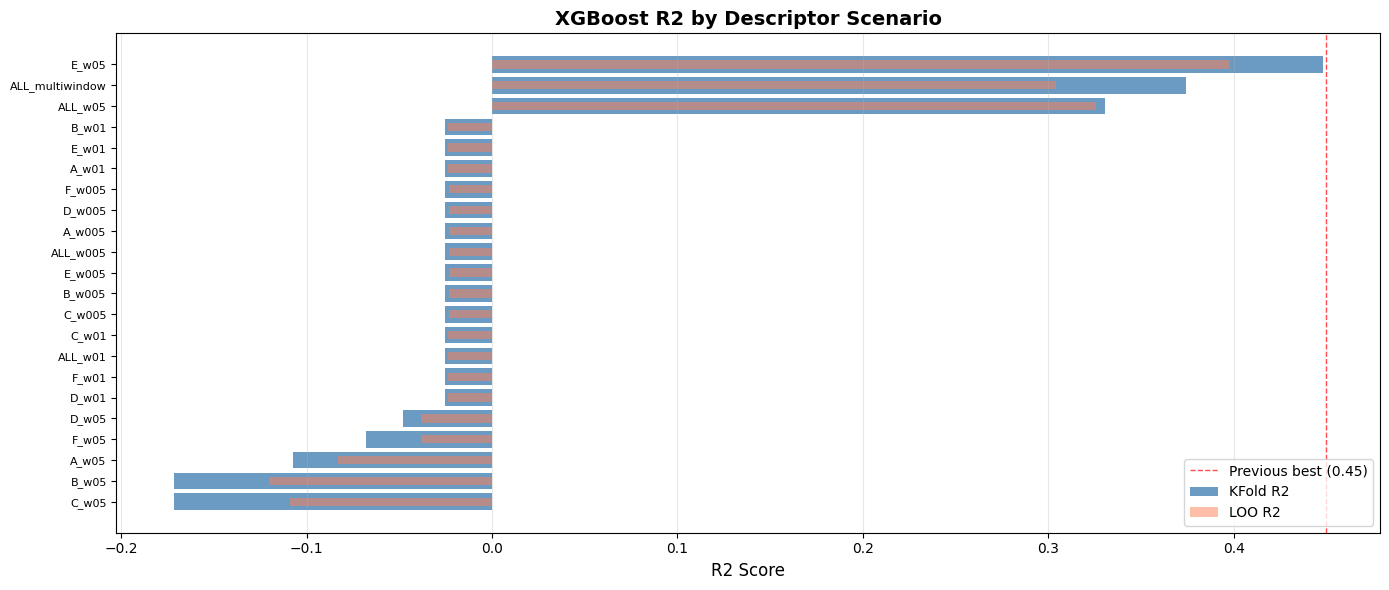

In [6]:
# ============================================================
# VISUALIZATION: R2 COMPARISON BAR CHART
# ============================================================
fig, ax = plt.subplots(figsize=(14, 6))

df_plot = df_summary.sort_values('KFold_R2', ascending=True)
y_pos = range(len(df_plot))

bars = ax.barh(y_pos, df_plot['KFold_R2'], color='steelblue', alpha=0.8, label='KFold R2')
if 'LOO_R2' in df_plot.columns:
    ax.barh(y_pos, df_plot['LOO_R2'], color='coral', alpha=0.5, height=0.4, label='LOO R2')

ax.set_yticks(y_pos)
ax.set_yticklabels(df_plot['CSV'].str.replace('desc_', '').str.replace('.csv', ''), fontsize=8)
ax.set_xlabel('R2 Score', fontsize=12)
ax.set_title('XGBoost R2 by Descriptor Scenario', fontsize=14, fontweight='bold')
ax.axvline(x=0.45, color='red', ls='--', lw=1, alpha=0.7, label='Previous best (0.45)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(CSV_DIR, 'r2_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

Best model: desc_E_w05.csv
KFold R2: 0.448
LOO R2: 0.39778839200773175

Feature Importance:
  E_pfrac_CBM               0.562 ||||||||||||||||||||||||||||
  E_pfrac_VBM               0.438 |||||||||||||||||||||


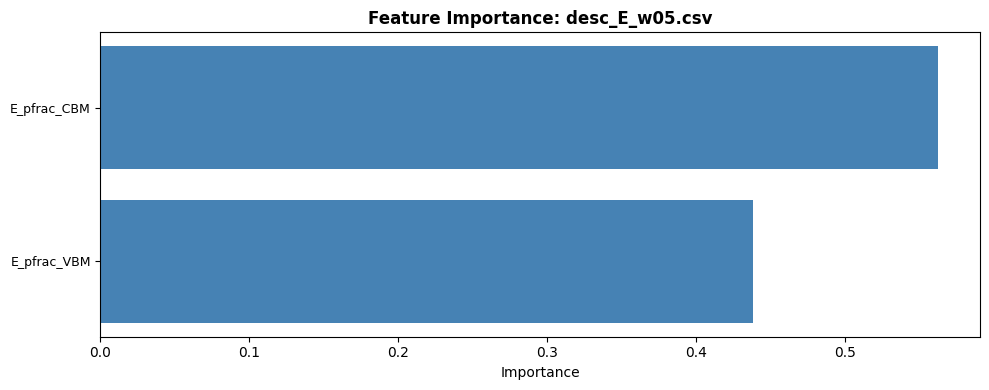

In [7]:
# ============================================================
# FEATURE IMPORTANCE FOR BEST MODEL
# ============================================================
best_csv = df_summary.iloc[0]['CSV']
best_res = [r for r in all_results if r.get('csv') == best_csv][0]

print(f"Best model: {best_csv}")
print(f"KFold R2: {best_res['kfold_R2']:.3f}")
print(f"LOO R2: {best_res.get('loo_R2', 'N/A')}")
print(f"\nFeature Importance:")

fi = best_res['feature_importance']
fi_sorted = sorted(fi.items(), key=lambda x: x[1], reverse=True)
for feat, imp in fi_sorted:
    bar = '|' * int(imp * 50)
    print(f"  {feat:<25} {imp:.3f} {bar}")

# Plot
fig, ax = plt.subplots(figsize=(10, max(4, len(fi_sorted)*0.4)))
feats = [f[0] for f in fi_sorted]
imps = [f[1] for f in fi_sorted]
ax.barh(range(len(feats)), imps, color='steelblue')
ax.set_yticks(range(len(feats)))
ax.set_yticklabels(feats, fontsize=9)
ax.set_xlabel('Importance')
ax.set_title(f'Feature Importance: {best_csv}', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(CSV_DIR, 'best_feature_importance.png'), dpi=150, bbox_inches='tight')
plt.show()

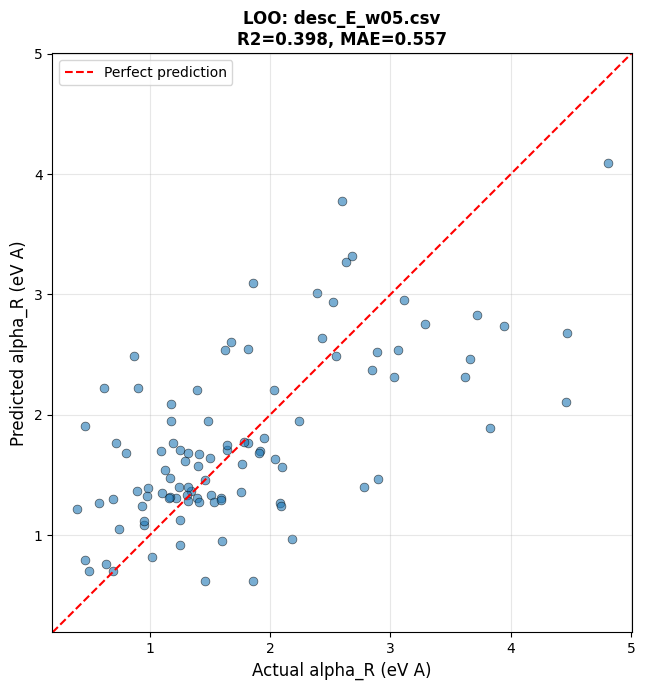

In [8]:
# ============================================================
# PRED vs ACTUAL SCATTER FOR BEST MODEL
# ============================================================
best_path = os.path.join(CSV_DIR, best_csv)
df_best = pd.read_csv(best_path)
feat_cols = [c for c in df_best.columns if c not in NON_FEATURE_COLS 
             and df_best[c].dtype in ['float64','float32','int64','int32']]

X = df_best[feat_cols].values
y = df_best['alpha_R'].values
valid = ~(np.isnan(X).any(axis=1) | np.isnan(y))
X, y = X[valid], y[valid]

# LOO predictions
model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1,
                     subsample=0.8, colsample_bytree=0.8,
                     reg_alpha=1.0, reg_lambda=1.0, random_state=42, verbosity=0)

y_pred = np.zeros(len(y))
loo = LeaveOneOut()
for train_idx, test_idx in loo.split(X):
    model.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = model.predict(X[test_idx])

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(y, y_pred, alpha=0.6, edgecolors='black', linewidth=0.5, s=40)
lims = [min(y.min(), y_pred.min()) - 0.2, max(y.max(), y_pred.max()) + 0.2]
ax.plot(lims, lims, 'r--', lw=1.5, label='Perfect prediction')
ax.set_xlabel('Actual alpha_R (eV A)', fontsize=12)
ax.set_ylabel('Predicted alpha_R (eV A)', fontsize=12)
ax.set_title(f'LOO: {best_csv}\nR2={r2_score(y,y_pred):.3f}, MAE={mean_absolute_error(y,y_pred):.3f}',
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.tight_layout()
plt.savefig(os.path.join(CSV_DIR, 'best_pred_vs_actual.png'), dpi=150, bbox_inches='tight')
plt.show()